In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [ ]:
!pip install neptune-client

     |████████████████████████████████| 215kB 5.9MB/s 
     |████████████████████████████████| 829kB 14.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 163kB 17.5MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 133kB 16.9MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.2-py2.py3-none-any.whl size=371803 sha256=10d4414ee07f7c411f25611db1ba57f80bff06fe507477bf856b4bf98663717e
  Stored in directory: /root/.cache/pip/wheels/25/e6/1f/37632e6dbe8d8eeb2d4809dc8ea707fe561f793aaa636b90a0
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=c86df8283bf5a868b7244eb13df86c50fd8b525950edfc624f907b0d69d61c26
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTETomek
from datetime import datetime
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import neptune

API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmM4OTBkYTAtY2JlYi00MGM4LWIzZTUtYzg1MTJkMzJkYjk3In0=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
dataset.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
#patientID
dataset['PatientId'] = dataset['PatientId'].astype('int64') 

#AppointmentID
dataset.drop(dataset[dataset['AppointmentID'].isna()].index, inplace = True)

#gender
dataset['Gender'] = dataset['Gender'].map({'F':1, 'M':0})

#neiberhood

import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['Neighbourhood'])
dataset = encoder.fit_transform(dataset)

#Age

dataset = dataset[dataset['Age'] >=0]

#no-show
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
Y = dataset["No-show"]
Y.tail()

110522    0
110523    0
110524    0
110525    0
110526    0
Name: No-show, dtype: int64

In [ ]:
X = dataset.loc[:, dataset.columns != 'No-show']
X.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_48,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
110522,2572134369293,5651768,1,1.462267e+09,1.465258e+09,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110523,3596266328735,5650093,1,1.462260e+09,1.465258e+09,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110524,15576631729893,5630692,1,1.461773e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110525,92134931435557,5630323,1,1.461770e+09,1.465258e+09,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110526,377511518121127,5629448,1,1.461764e+09,1.465258e+09,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
x, x_val, y, y_val = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)

In [ ]:
dataset = x

In [ ]:
dataset['No-show'] =y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
64281,468148177676828,5401357,0,1.456482e+09,1.464048e+09,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
42103,74734263232929,5612074,1,1.461571e+09,1.463357e+09,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98202,79722691475274,5682365,0,1.462897e+09,1.464826e+09,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
58061,143523574527737,5744655,1,1.464604e+09,1.464566e+09,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86,3376224477447,5595347,0,1.460983e+09,1.461888e+09,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48967,27259357386825,5545622,1,1.459866e+09,1.462234e+09,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
65595,8546883619353,5608251,1,1.461159e+09,1.463357e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66429,59578539883535,5604809,1,1.461140e+09,1.462752e+09,65,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80281,3412872332627,5667202,0,1.462520e+09,1.462493e+09,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
X = dataset.loc[:, dataset.columns != 'No-show']
X.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_48,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
48967,27259357386825,5545622,1,1.459866e+09,1.462234e+09,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
65595,8546883619353,5608251,1,1.461159e+09,1.463357e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66429,59578539883535,5604809,1,1.461140e+09,1.462752e+09,65,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80281,3412872332627,5667202,0,1.462520e+09,1.462493e+09,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16592,657597498615,5603279,1,1.461088e+09,1.462320e+09,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
Y = dataset["No-show"]
Y.tail()

48967    0
65595    0
66429    0
80281    0
16592    1
Name: No-show, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)

In [ ]:
def model(X_train, y_train, X_test,y_test, search, name, tags):
  
  #print(search.get_params())
  # y_train = train["NoShow"]
  # y_test = test["NoShow"]

  # X_train = train.loc[:, train.columns != 'NoShow']
  # X_test = test.loc[:, test.columns != 'NoShow']
                
  search = search.fit(X_train, y_train)

  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags(["Magdalena Cebula"])
  #neptune.append_tags([str(space4dt)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [ ]:
clf =  xgb.XGBClassifier(random_state=0)

In [ ]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

[0 0 0 ... 0 0 0]
Accuracy: 79.83%
 f1  0.007909045971329708 
 recall 0.003982080637132902 
 precision 0.5714285714285714
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-547
Confusion matrix:
 [[7933    6]
 [2001    8]]


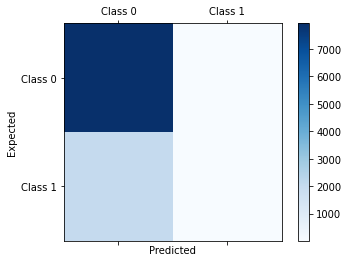

[0.00000000e+00 7.55762691e-04 1.00000000e+00] [0.         0.00398208 1.        ] [2 1 0]


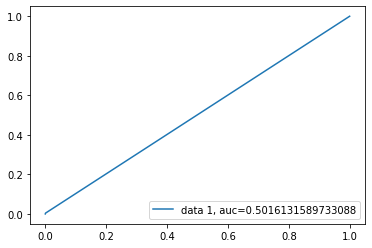

In [ ]:
model(X_train, y_train, X_test,y_test, clf, 'XGBClassifier', ['XGBClassifier', 'Raw', 'EDA2'])

In [ ]:
#smotetomek
X = dataset.loc[:, dataset.columns != 'No-show']
Y = dataset["No-show"]

smote_tomek = SMOTETomek(random_state=0)
X_smote, y_smote = smote_tomek.fit_resample(X, Y)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
NoShow = pd.DataFrame(data = X_smote, columns = X.columns)
YNoShow = pd.DataFrame(data = y_smote, columns = ["No-show"])
NoShow["No-show"] = YNoShow


In [ ]:
NoShow

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,4.681482e+14,5.401357e+06,0.000000,1.456482e+09,1.464048e+09,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
1,7.473426e+13,5.612074e+06,1.000000,1.461571e+09,1.463357e+09,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
2,7.972269e+13,5.682365e+06,0.000000,1.462897e+09,1.464826e+09,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
3,9.413494e+13,5.640253e+06,1.000000,1.461925e+09,1.463098e+09,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
4,3.881118e+13,5.647384e+06,0.000000,1.462196e+09,1.464826e+09,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,1.461920e+09,1.464908e+09,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
def split_and_model(data, tags):
  X = data.loc[:, data.columns != 'No-show']
  X.tail()
  Y = data["No-show"]
  Y.tail()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)
  model(X_train, y_train, X_test,y_test, clf, 'XGBClassifier', tags)


In [ ]:
split_and_model(NoShow,['XGBClassifier', 'SMOTETomek', 'EDA2'])

NameError: ignored

In [ ]:
dataset = NoShow

In [ ]:
#date
dataset['ScheduledDay'] =  dataset['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
dataset['AppointmentDay'] =  dataset['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
dataset['Waiting_Time_days'] = dataset['AppointmentDay'] - dataset['ScheduledDay']
dataset['Waiting_Time_days'] = dataset['Waiting_Time_days'].dt.days
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
dataset[dataset['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
10712,2.425226e+13,5.664962e+06,1.000000,2016-05-05 13:43:58.000000,2016-05-04 00:00:00.000000,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
53563,7.839273e+12,5.679978e+06,0.000000,2016-05-10 10:51:53.000000,2016-05-09 00:00:00.000000,38.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,-2
68997,3.787482e+12,5.655637e+06,0.000000,2016-05-04 06:50:57.000000,2016-05-03 00:00:00.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
73345,9.982316e+14,5.686628e+06,1.000000,2016-05-11 13:49:20.000000,2016-05-05 00:00:00.000000,81.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-7
81674,2.425226e+13,5.664760e+06,1.000000,2016-05-05 12:58:32.027898,2016-05-04 09:34:28.606704,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
84405,9.980975e+14,5.709029e+06,1.000000,2016-05-18 11:11:26.345661,2016-05-15 01:52:16.325405,52.851196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.347516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652484,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-4
105904,9.982197e+14,5.688607e+06,1.000000,2016-05-12 04:25:54.214814,2016-05-05 21:22:05.359811,78.513189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.030701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
dataset = dataset[dataset['Waiting_Time_days'] >=-1]

In [ ]:
dataset[dataset['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,4.681482e+14,5.401357e+06,0.000000,1.456482e+09,1.464048e+09,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87
1,7.473426e+13,5.612074e+06,1.000000,1.461571e+09,1.463357e+09,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20
2,7.972269e+13,5.682365e+06,0.000000,1.462897e+09,1.464826e+09,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22
3,9.413494e+13,5.640253e+06,1.000000,1.461925e+09,1.463098e+09,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13
4,3.881118e+13,5.647384e+06,0.000000,1.462196e+09,1.464826e+09,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,1.461920e+09,1.464908e+09,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

[0 0 1 ... 1 1 1]
Accuracy: 85.33%
 f1  0.8438008460787504 
 recall 0.792602781598655 
 precision 0.9020699252043833
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-549
Confusion matrix:
 [[5981  563]
 [1357 5186]]


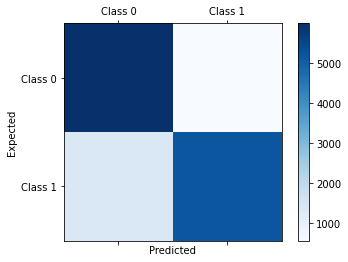

[0.         0.08603301 1.        ] [0.         0.79260278 1.        ] [2 1 0]


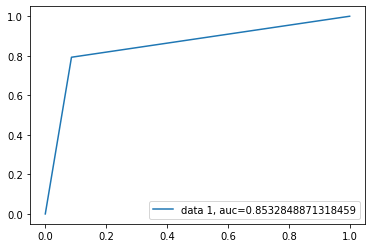

In [ ]:
split_and_model(dataset,['XGBClassifier', 'SMOTETomek','Waiting_Time_days', 'EDA2'])

In [ ]:
#date
dataset['ScheduledDay'] =  dataset['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
dataset['AppointmentDay'] =  dataset['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

TypeError: ignored

In [ ]:
dataset['ScheduledWeekday'] = dataset['ScheduledDay'].dt.dayofweek
dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[1 0 1 ... 1 1 1]
Accuracy: 86.68%
 f1  0.8537628995721117 
 recall 0.7776249426868409 
 precision 0.9464285714285714
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-550
Confusion matrix:
 [[6256  288]
 [1455 5088]]


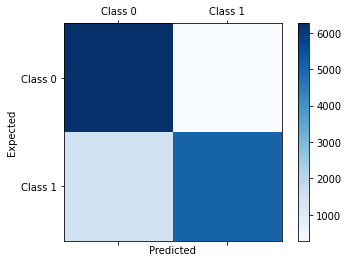

[0.         0.04400978 1.        ] [0.         0.77762494 1.        ] [2 1 0]


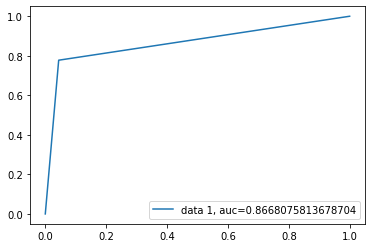

In [ ]:
split_and_model(dataset,['XGBClassifier', 'SMOTETomek', 'AppointmentWeekday','EDA2'])

In [ ]:
dataset[dataset['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday


In [ ]:
#date
dataset['ScheduledDay'] =  dataset['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
dataset['AppointmentDay'] =  dataset['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dataset['ScheduledDay_in_year'] = dataset['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
dataset['AppointmentDay_in_year'] = dataset['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,57,145
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,116,137
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,131,154
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,120,134
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,123,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[1 0 1 ... 1 1 1]
Accuracy: 86.68%
 f1  0.8537628995721117 
 recall 0.7776249426868409 
 precision 0.9464285714285714
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-551
Confusion matrix:
 [[6256  288]
 [1455 5088]]


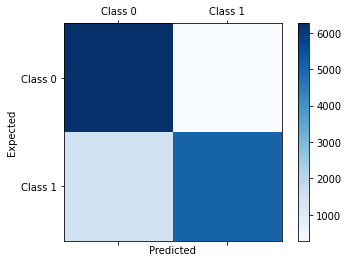

[0.         0.04400978 1.        ] [0.         0.77762494 1.        ] [2 1 0]


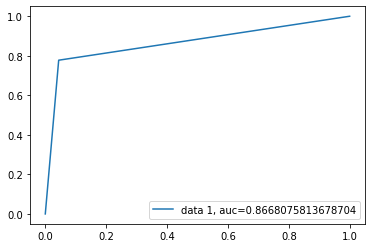

In [ ]:
#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

split_and_model(dataset,['XGBClassifier', 'SMOTETomek', 'ScheduledDay_in_year','AppointmentDay_in_year','EDA2'])

In [ ]:
#date
dataset['ScheduledDay'] =  dataset['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
dataset['AppointmentDay'] =  dataset['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dataset['ScheduledHour'] = dataset['ScheduledDay'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,57,145,10
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,116,137,7
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,131,154,16
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,120,134,10
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,123,154,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
dataset.drop('ScheduledDay', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataset

,PatientId,AppointmentID,Gender,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour
0,4.681482e+14,5.401357e+06,0.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,57,145,10
1,7.473426e+13,5.612074e+06,1.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,116,137,7
2,7.972269e+13,5.682365e+06,0.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,131,154,16
3,9.413494e+13,5.640253e+06,1.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,120,134,10
4,3.881118e+13,5.647384e+06,0.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,123,154,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
dataset.drop('AppointmentDay', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataset

,PatientId,AppointmentID,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour
0,4.681482e+14,5.401357e+06,0.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,57,145,10
1,7.473426e+13,5.612074e+06,1.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,116,137,7
2,7.972269e+13,5.682365e+06,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,131,154,16
3,9.413494e+13,5.640253e+06,1.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,120,134,10
4,3.881118e+13,5.647384e+06,0.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,123,154,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.002084,1,34,4,3,120,154,8
130870,1.897185e+13,5.5907

In [ ]:
dataset.drop('AppointmentID', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[1 0 1 ... 1 1 1]
Accuracy: 87.30%
 f1  0.8578028747433265 
 recall 0.7661623108665749 
 precision 0.9743440233236151
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-552
Confusion matrix:
 [[6412  132]
 [1530 5013]]


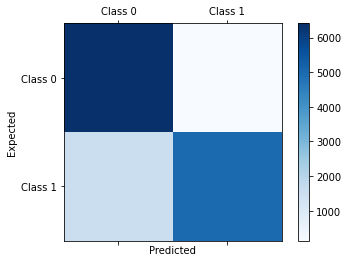

[0.         0.02017115 1.        ] [0.         0.76616231 1.        ] [2 1 0]


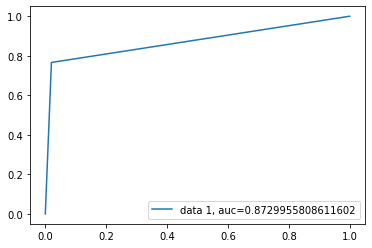

In [ ]:
split_and_model(dataset,['XGBClassifier', 'SMOTETomek', 'ScheduledHour','EDA2'])

In [ ]:
x_val['No-show'] = y_val

In [ ]:
x_val

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
74732,62166383748496,5686941,1,1.462976e+09,1.463098e+09,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46099,6529855591596,5682800,0,1.462908e+09,1.462838e+09,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58059,2314564212973,5673355,1,1.462785e+09,1.462752e+09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43393,98542625315963,5710655,0,1.463505e+09,1.463443e+09,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30578,7881337869312,5741628,1,1.464593e+09,1.464566e+09,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,33534783483176,5738875,0,1.464177e+09,1.464134e+09,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
50126,31693127444723,5647062,0,1.462193e+09,1.462147e+09,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
107486,15338272715796,5782509,0,1.465299e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91756,55336915167382,5730109,1,1.464077e+09,1.465258e+09,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


[0 0 0 ... 0 0 0]
Accuracy: 79.75%
 f1  0.026086956521739132 
 recall 0.013452914798206279 
 precision 0.42857142857142855
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-564
Confusion matrix:
 [[879   4]
 [220   3]]


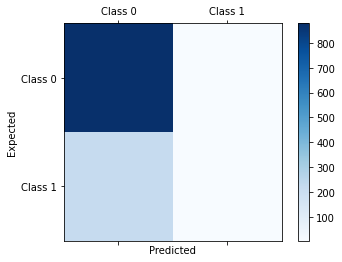

[0.         0.00453001 1.        ] [0.         0.01345291 1.        ] [2 1 0]


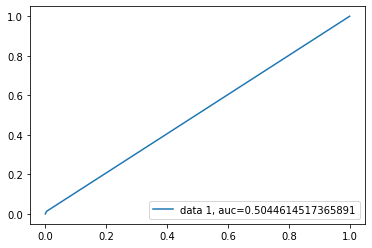

In [ ]:
split_and_model(x_val,['XGBClassifier', 'SMOTETomek', 'Validation','EDA2'])

In [ ]:
temp = dataset[dataset['PatientId']==3596266328735].sort_values('AppointmentDay')
temp.assign(sum=temp['No-show'].cumsum())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour,sum
915,3596266328735,5637984,1,2016-04-29 07:35:40,2016-04-29,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,7,0
60707,3596266328735,5558973,1,2016-04-08 07:13:33,2016-05-02,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23,4,0,99,123,7,1
98678,3596266328735,5662056,1,2016-05-05 08:03:27,2016-06-03,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,28,3,4,126,155,8,1
110523,3596266328735,5650093,1,2016-05-03 07:27:33,2016-06-07,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,34,1,1,124,159,7,1


In [ ]:
tmp = dataset

In [ ]:
tmp['tmp'] = dataset.sort_values('AppointmentDay').groupby('PatientId')['PatientId'].transform('cumsum')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tmp[tmp['PatientId']==3596266328735]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour,tmp
915,3596266328735,5637984,1,2016-04-29 07:35:40,2016-04-29,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,7,3596266328735
60707,3596266328735,5558973,1,2016-04-08 07:13:33,2016-05-02,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23,4,0,99,123,7,7192532657470
98678,3596266328735,5662056,1,2016-05-05 08:03:27,2016-06-03,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,28,3,4,126,155,8,10788798986205
110523,3596266328735,5650093,1,2016-05-03 07:27:33,2016-06-07,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,34,1,1,124,159,7,14385065314940


In [ ]:
dataset.sort_values('AppointmentDate').groupby('PatientId')['PatientId']

0          29872499824296
2151         725775968562
2152       94755722517728
2153       35387553979251
2154      732498986588399
               ...       
92055      66183781398188
99217     164849472623584
99218       4137342572994
99224    2346595091443785
91900        259609909971
Name: PatientId, Length: 110527, dtype: int64

In [ ]:
dataset.drop(['AppointmentID'], axis=1, inplace=True)
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour,tmp
0,29872499824296,1,2016-04-29 18:38:08,2016-04-29,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,120,120,18,29872499824296
1,558997776694438,0,2016-04-29 16:08:27,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,16,1117995553388876
2,4262962299951,1,2016-04-29 16:19:04,2016-04-29,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,16,4262962299951
3,867951213174,1,2016-04-29 17:29:31,2016-04-29,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,17,867951213174
4,8841186448183,1,2016-04-29 16:07:23,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,120,120,16,8841186448183


In [ ]:
dataset.drop(['ScheduledDay'], axis=1, inplace=True)
dataset.drop(['AppointmentDay'], axis=1, inplace=True)
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PatientId,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledDay_in_year,AppointmentDay_in_year,ScheduledHour,tmp
0,29872499824296,1,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,120,120,18,29872499824296
1,558997776694438,0,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,16,1117995553388876
2,4262962299951,1,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,16,4262962299951
3,867951213174,1,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,120,120,17,867951213174
4,8841186448183,1,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,120,120,16,8841186448183
